## RNN

Generally DL models shape = [batch size, # input features]

RNN i/p size is shape = [batch size, # time steps, # dims]

dims -> number of dimensions, univariate = 1, bivariate = 2

If return_sequences = True not present in RNN keras layer, then it means output is being fed to the final Dense layer.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

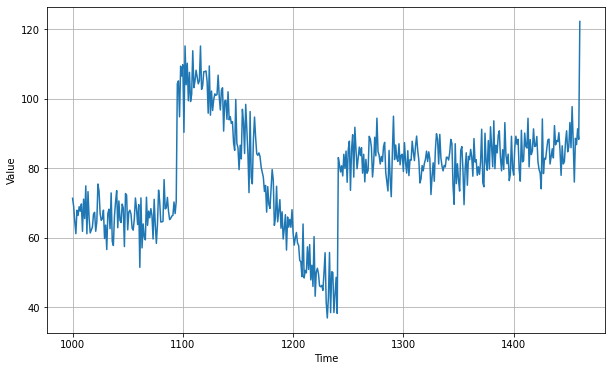

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
# tf.keras.backend.clear_session()                    # clears any internal variables
tf.random.set_seed(51)
np.random.seed(51)

In [6]:
dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

In [10]:
model = Sequential([
    layers.InputLayer(input_shape=[None]),                        # input_shape=[None] means model can take sequences of any length
    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),          # adds 1 more dimension (window_size)
    layers.SimpleRNN(40, return_sequences=True),
    layers.SimpleRNN(40),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 100.0)                            # scale outputs by 100
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [12]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [13]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [14]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [15]:
# tuning learning rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [16]:
epochs = 100
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [17]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
8/8 [==============================] - 5s 70ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 1s 64ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 1s 67ms/step - loss: 193.5110 - mae: 194.0110
Epoch 4/100
8/8 [==============================] - 1s 65ms/step - loss: 191.9081 - mae: 192.4081
Epoch 5/100
8/8 [==============================] - 1s 70ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 1s 63ms/step - loss: 187.8583 - mae: 188.3583
Epoch 7/100
8/8 [==============================] - 1s 66ms/step - loss: 185.3787 - mae: 185.8787
Epoch 8/100
8/8 [==============================] - 1s 77ms/step - loss: 182.5484 - mae: 183.0484
Epoch 9/100
8/8 [==============================] - 1s 68ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 1s 65ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [===========

(1e-08, 0.0001, 0.0, 30.0)

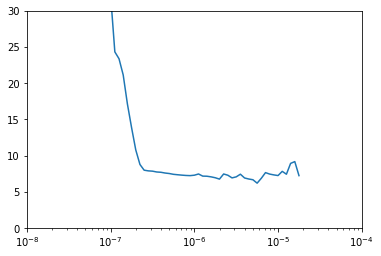

In [18]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [20]:
history.history['lr']

[1e-08,
 1.1220185e-08,
 1.2589254e-08,
 1.41253755e-08,
 1.5848931e-08,
 1.7782794e-08,
 1.9952623e-08,
 2.2387212e-08,
 2.5118863e-08,
 2.8183829e-08,
 3.1622776e-08,
 3.548134e-08,
 3.981072e-08,
 4.4668358e-08,
 5.011872e-08,
 5.6234132e-08,
 6.309573e-08,
 7.079458e-08,
 7.943282e-08,
 8.9125095e-08,
 1e-07,
 1.12201846e-07,
 1.2589254e-07,
 1.4125375e-07,
 1.5848931e-07,
 1.7782794e-07,
 1.9952623e-07,
 2.2387212e-07,
 2.5118865e-07,
 2.8183828e-07,
 3.1622776e-07,
 3.5481338e-07,
 3.9810718e-07,
 4.466836e-07,
 5.0118723e-07,
 5.623413e-07,
 6.3095735e-07,
 7.079458e-07,
 7.9432823e-07,
 8.912509e-07,
 1e-06,
 1.1220185e-06,
 1.2589254e-06,
 1.4125376e-06,
 1.5848932e-06,
 1.7782794e-06,
 1.9952622e-06,
 2.2387212e-06,
 2.5118864e-06,
 2.8183829e-06,
 3.1622776e-06,
 3.548134e-06,
 3.9810716e-06,
 4.466836e-06,
 5.0118724e-06,
 5.6234135e-06,
 6.3095736e-06,
 7.0794576e-06,
 7.943282e-06,
 8.91251e-06,
 1e-05,
 1.1220184e-05,
 1.2589254e-05,
 1.4125376e-05,
 1.5848931e-05,
 1.77

In [27]:
# making new model by fixing learning rate

model = Sequential([
    layers.InputLayer(input_shape=[None]),                        # input_shape=[None] means model can take sequences of any length
    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),          # adds 1 more dimension (window_size)
    layers.SimpleRNN(40, return_sequences=True),
    layers.SimpleRNN(40),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 100.0)                            # scale outputs by 100
])

In [28]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=7e-6, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [29]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [30]:
early_stopping    = EarlyStopping(monitor='loss', patience=20)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [31]:
epochs = 300
callbacks = [early_stopping, model_checkpoint]

In [32]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/300
8/8 [==============================] - 2s 63ms/step - loss: 43.4953 - mae: 43.9942
Epoch 2/300
8/8 [==============================] - 1s 65ms/step - loss: 24.5392 - mae: 25.0363
Epoch 3/300
8/8 [==============================] - 1s 65ms/step - loss: 19.3681 - mae: 19.8630
Epoch 4/300
8/8 [==============================] - 1s 66ms/step - loss: 13.0451 - mae: 13.5350
Epoch 5/300
8/8 [==============================] - 1s 63ms/step - loss: 8.8996 - mae: 9.3840
Epoch 6/300
8/8 [==============================] - 1s 63ms/step - loss: 7.7076 - mae: 8.1876
Epoch 7/300
8/8 [==============================] - 1s 59ms/step - loss: 7.8089 - mae: 8.2940
Epoch 8/300
8/8 [==============================] - 1s 60ms/step - loss: 7.2726 - mae: 7.7549
Epoch 9/300
8/8 [==============================] - 1s 60ms/step - loss: 6.9264 - mae: 7.4053
Epoch 10/300
8/8 [==============================] - 1s 61ms/step - loss: 6.7257 - mae: 7.2060
Epoch 11/300
8/8 [==============================] - 1s 60ms/s

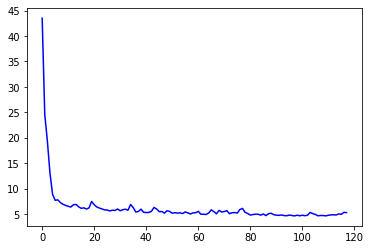

In [36]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

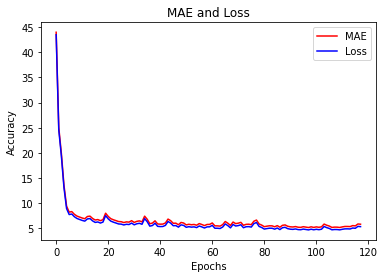

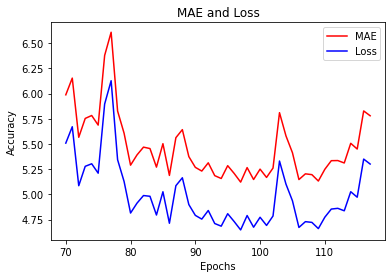

<Figure size 432x288 with 0 Axes>

In [35]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[70:]
mae_zoom = mae[70:]
loss_zoom = loss[70:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

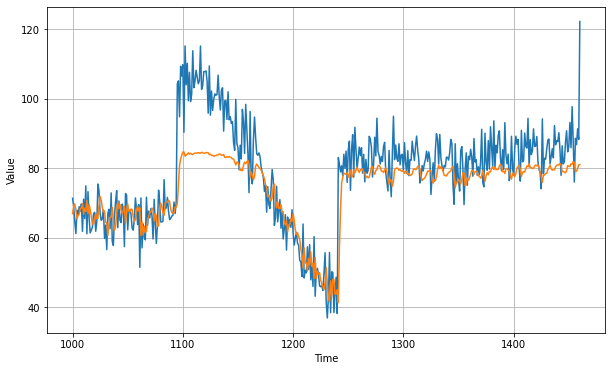

In [39]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [40]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.9768696

## LSTM

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [45]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

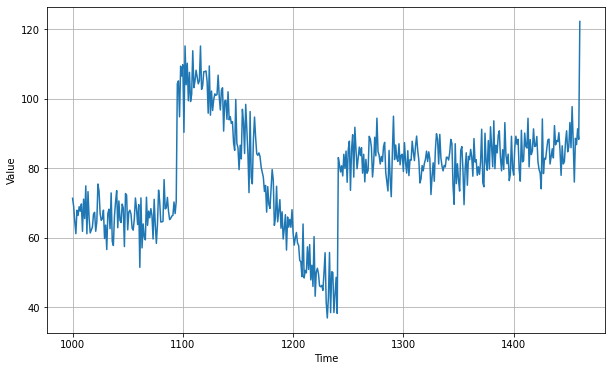

In [46]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [47]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [48]:
tf.random.set_seed(51)
np.random.seed(51)

In [49]:
dataset = windowed_dataset(x_train, window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

In [51]:
model = Sequential([
    layers.InputLayer(input_shape=[None]),                        # input_shape=[None] means model can take sequences of any length
    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),          # adds 1 more dimension (window_size)
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 100.0)                            # scale outputs by 100
])

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_8 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [53]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [56]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [54]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [55]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [57]:
epochs = 100
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [58]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
31/31 [==============================] - 10s 22ms/step - loss: 21.5167 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 1s 23ms/step - loss: 21.1522 - mae: 21.6444
Epoch 3/100
31/31 [==============================] - 1s 22ms/step - loss: 20.7302 - mae: 21.2236
Epoch 4/100
31/31 [==============================] - 1s 23ms/step - loss: 20.2834 - mae: 20.7757
Epoch 5/100
31/31 [==============================] - 1s 23ms/step - loss: 19.7897 - mae: 20.2855
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: 19.1782 - mae: 19.6696
Epoch 7/100
31/31 [==============================] - 1s 22ms/step - loss: 18.2410 - mae: 18.7333
Epoch 8/100
31/31 [==============================] - 1s 21ms/step - loss: 17.4825 - mae: 17.9748
Epoch 9/100
31/31 [==============================] - 1s 22ms/step - loss: 17.1597 - mae: 17.6529
Epoch 10/100
31/31 [==============================] - 1s 22ms/step - loss: 16.8547 - mae: 17.3463
Epoch 11/100
31/31 [========

(1e-08, 0.0001, 0.0, 30.0)

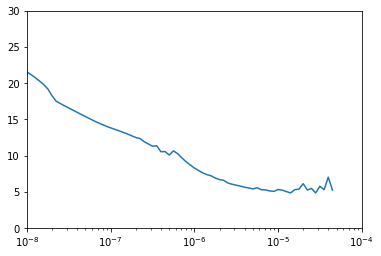

In [59]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [60]:
history.history['lr']

[1e-08,
 1.1220185e-08,
 1.2589254e-08,
 1.41253755e-08,
 1.5848931e-08,
 1.7782794e-08,
 1.9952623e-08,
 2.2387212e-08,
 2.5118863e-08,
 2.8183829e-08,
 3.1622776e-08,
 3.548134e-08,
 3.981072e-08,
 4.4668358e-08,
 5.011872e-08,
 5.6234132e-08,
 6.309573e-08,
 7.079458e-08,
 7.943282e-08,
 8.9125095e-08,
 1e-07,
 1.12201846e-07,
 1.2589254e-07,
 1.4125375e-07,
 1.5848931e-07,
 1.7782794e-07,
 1.9952623e-07,
 2.2387212e-07,
 2.5118865e-07,
 2.8183828e-07,
 3.1622776e-07,
 3.5481338e-07,
 3.9810718e-07,
 4.466836e-07,
 5.0118723e-07,
 5.623413e-07,
 6.3095735e-07,
 7.079458e-07,
 7.9432823e-07,
 8.912509e-07,
 1e-06,
 1.1220185e-06,
 1.2589254e-06,
 1.4125376e-06,
 1.5848932e-06,
 1.7782794e-06,
 1.9952622e-06,
 2.2387212e-06,
 2.5118864e-06,
 2.8183829e-06,
 3.1622776e-06,
 3.548134e-06,
 3.9810716e-06,
 4.466836e-06,
 5.0118724e-06,
 5.6234135e-06,
 6.3095736e-06,
 7.0794576e-06,
 7.943282e-06,
 8.91251e-06,
 1e-05,
 1.1220184e-05,
 1.2589254e-05,
 1.4125376e-05,
 1.5848931e-05,
 1.77

In [61]:
# making new model by fixing learning rate

model = Sequential([
    layers.InputLayer(input_shape=[None]),                        # input_shape=[None] means model can take sequences of any length
    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),          # adds 1 more dimension (window_size)
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 100.0)                            # scale outputs by 100
])

In [65]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [66]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [68]:
early_stopping    = EarlyStopping(monitor='loss', patience=20)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [69]:
epochs = 300
callbacks = [early_stopping, model_checkpoint]

In [70]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/300
31/31 [==============================] - 7s 22ms/step - loss: 18.6612 - mae: 19.1538
Epoch 2/300
31/31 [==============================] - 1s 22ms/step - loss: 7.7490 - mae: 8.2378
Epoch 3/300
31/31 [==============================] - 1s 22ms/step - loss: 6.1433 - mae: 6.6224
Epoch 4/300
31/31 [==============================] - 1s 22ms/step - loss: 6.6813 - mae: 7.1657
Epoch 5/300
31/31 [==============================] - 1s 22ms/step - loss: 6.0188 - mae: 6.5017
Epoch 6/300
31/31 [==============================] - 1s 22ms/step - loss: 5.3696 - mae: 5.8497
Epoch 7/300
31/31 [==============================] - 1s 22ms/step - loss: 4.9906 - mae: 5.4684
Epoch 8/300
31/31 [==============================] - 1s 22ms/step - loss: 5.1006 - mae: 5.5807
Epoch 9/300
31/31 [==============================] - 1s 21ms/step - loss: 5.4062 - mae: 5.8877
Epoch 10/300
31/31 [==============================] - 1s 23ms/step - loss: 5.7917 - mae: 6.2747
Epoch 11/300
31/31 [===========================

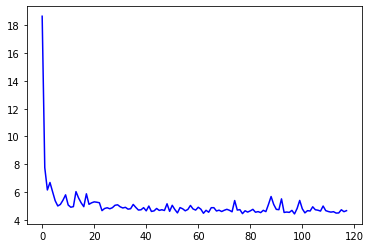

In [71]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

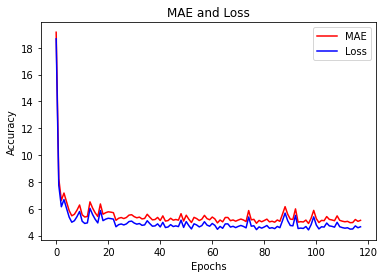

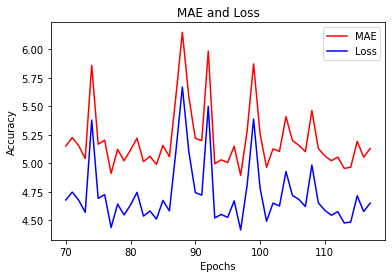

<Figure size 432x288 with 0 Axes>

In [72]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[70:]
mae_zoom = mae[70:]
loss_zoom = loss[70:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

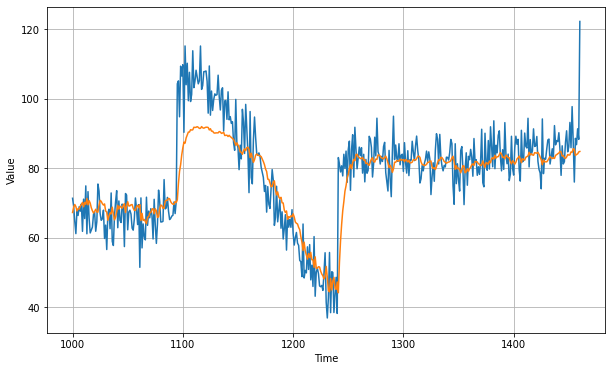

In [73]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [74]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.819246

In [75]:
best_model = tf.keras.models.load_model('best_model.h5')

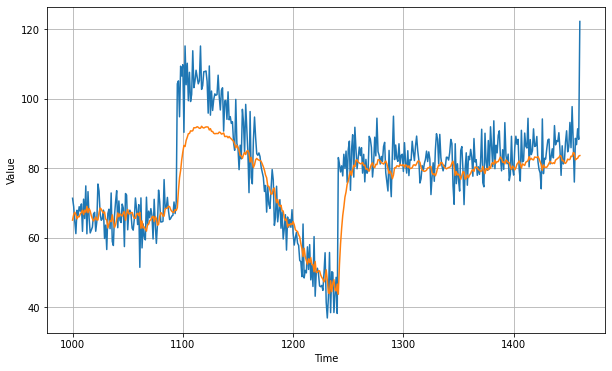

In [76]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(best_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [77]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.925696

## Exercise 15

In class you learned about RNNs and LSTMs for prediction, as well as a simple methodology to pick a decent learning rate for the stochastic gradient descent optimizer. In this exercise you’ll take a synthetic data set and write the code to pick the learning rate and then train on it to get an MAE of < 3



In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


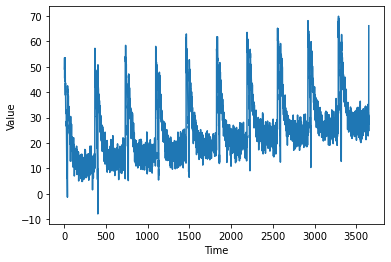

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

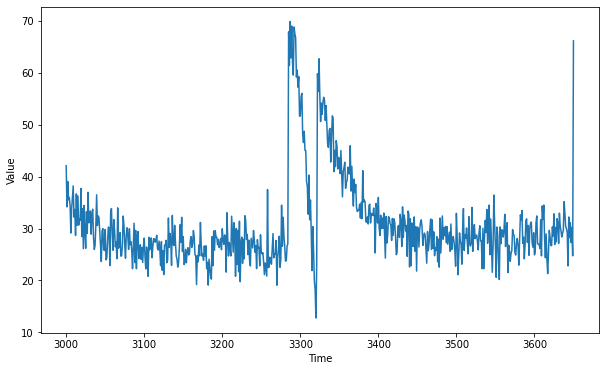

In [4]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
tf.random.set_seed(51)
np.random.seed(51)

In [7]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [8]:
model = Sequential([
    layers.InputLayer(input_shape=[None]),                        # input_shape=[None] means model can take sequences of any length
    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),          # adds 1 more dimension (window_size)
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 100.0)                            # scale outputs by 100
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [11]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [12]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [13]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [14]:
epochs = 100
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [15]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
94/94 [==============================] - 9s 23ms/step - loss: 8.5331 - mae: 9.0204
Epoch 2/100
94/94 [==============================] - 2s 22ms/step - loss: 8.0548 - mae: 8.5392
Epoch 3/100
94/94 [==============================] - 2s 23ms/step - loss: 7.7249 - mae: 8.2080
Epoch 4/100
94/94 [==============================] - 2s 22ms/step - loss: 7.5026 - mae: 7.9862
Epoch 5/100
94/94 [==============================] - 2s 23ms/step - loss: 7.3488 - mae: 7.8287
Epoch 6/100
94/94 [==============================] - 2s 22ms/step - loss: 7.2340 - mae: 7.7112
Epoch 7/100
94/94 [==============================] - 2s 22ms/step - loss: 7.1368 - mae: 7.6127
Epoch 8/100
94/94 [==============================] - 2s 22ms/step - loss: 7.0504 - mae: 7.5257
Epoch 9/100
94/94 [==============================] - 2s 23ms/step - loss: 6.9634 - mae: 7.4375
Epoch 10/100
94/94 [==============================] - 2s 22ms/step - loss: 6.8760 - mae: 7.3503
Epoch 11/100
94/94 [=============================

(1e-08, 0.0001, 0.0, 30.0)

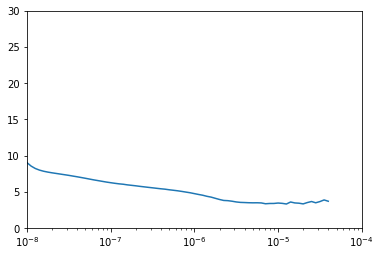

In [16]:
plt.semilogx(history.history['lr'], history.history['mae'])
plt.axis([1e-8, 1e-4, 0, 30])

In [17]:
history.history

{'loss': [8.533123016357422,
  8.054813385009766,
  7.724854946136475,
  7.5026021003723145,
  7.348779201507568,
  7.233988285064697,
  7.136765480041504,
  7.050378799438477,
  6.963384628295898,
  6.875957012176514,
  6.78769588470459,
  6.6884379386901855,
  6.592136859893799,
  6.489777088165283,
  6.382424354553223,
  6.272377014160156,
  6.166932106018066,
  6.066022872924805,
  5.964938640594482,
  5.868138313293457,
  5.779843330383301,
  5.698826313018799,
  5.622232437133789,
  5.564342975616455,
  5.482100486755371,
  5.418179035186768,
  5.3518757820129395,
  5.278088092803955,
  5.210219860076904,
  5.14349365234375,
  5.078306198120117,
  5.009357452392578,
  4.944662094116211,
  4.889945030212402,
  4.808413982391357,
  4.738195896148682,
  4.667323589324951,
  4.579430103302002,
  4.4864091873168945,
  4.39483118057251,
  4.27648401260376,
  4.161668300628662,
  4.054150104522705,
  3.904144048690796,
  3.7959091663360596,
  3.629941701889038,
  3.4696671962738037,
  3

In [18]:
# making new model by fixing learning rate

model = Sequential([
    layers.InputLayer(input_shape=[None]),                        # input_shape=[None] means model can take sequences of any length
    layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),          # adds 1 more dimension (window_size)
    layers.Bidirectional(layers.LSTM(32, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1),
    layers.Lambda(lambda x: x * 100.0)                            # scale outputs by 100
])

In [19]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
loss        = tf.keras.losses.Huber()
metrics     = ['mae']

In [20]:
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [21]:
early_stopping    = EarlyStopping(monitor='mae', patience=70)
model_checkpoint  = ModelCheckpoint(monitor='mae', filepath='./best_model.h5', save_best_only=True)

In [22]:
epochs = 500
callbacks = [early_stopping, model_checkpoint]

In [23]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/500
94/94 [==============================] - 8s 22ms/step - loss: 7.2759 - mae: 7.7504
Epoch 2/500
94/94 [==============================] - 2s 22ms/step - loss: 3.6832 - mae: 4.1486
Epoch 3/500
94/94 [==============================] - 2s 23ms/step - loss: 3.2354 - mae: 3.7031
Epoch 4/500
94/94 [==============================] - 2s 23ms/step - loss: 3.0581 - mae: 3.5228
Epoch 5/500
94/94 [==============================] - 2s 22ms/step - loss: 3.2427 - mae: 3.7133
Epoch 6/500
94/94 [==============================] - 2s 22ms/step - loss: 3.0073 - mae: 3.4725
Epoch 7/500
94/94 [==============================] - 2s 22ms/step - loss: 2.9387 - mae: 3.4018
Epoch 8/500
94/94 [==============================] - 2s 22ms/step - loss: 3.0559 - mae: 3.5225
Epoch 9/500
94/94 [==============================] - 2s 22ms/step - loss: 2.9324 - mae: 3.3971
Epoch 10/500
94/94 [==============================] - 2s 22ms/step - loss: 3.1095 - mae: 3.5733
Epoch 11/500
94/94 [=============================

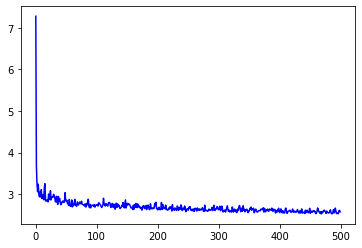

In [24]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

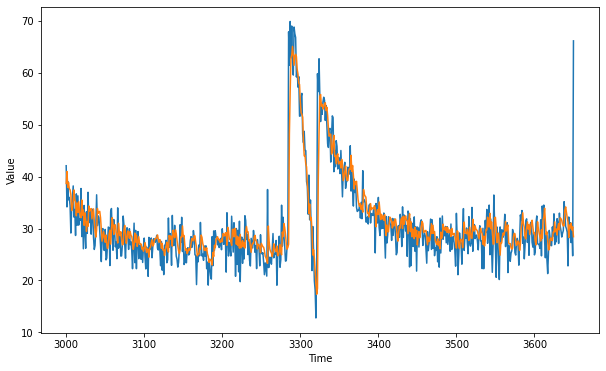

In [25]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.1495318

In [27]:
best_model = tf.keras.models.load_model('best_model.h5')

In [28]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, None, 1)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          8704      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_3 (Lambda)            (None, 1)                 0         
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


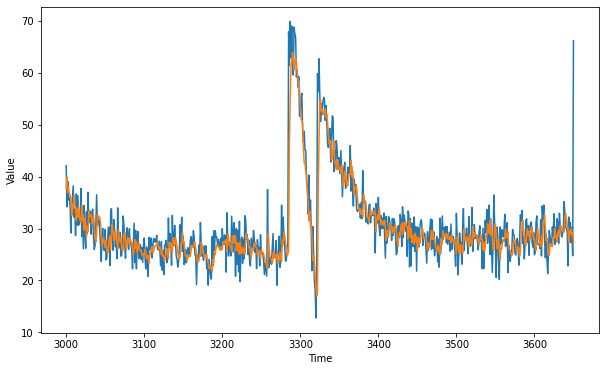

In [29]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(best_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [30]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.0434391